In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
from pyDOE import lhs
import random
import os
import time

plt.rcParams.update({'font.size':18})

In [3]:
def seed_torch(seed=1024):
#     random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
#     torch.use_deterministic_algorithms(True)  # 有检查操作，看下文区别
 
seed_torch(314)

## 超参数

In [4]:
domain = (0,4)
xmin, xmax = domain
backbone_layers = [1] + [100]*2 + [1]
nn_lam_layers = [1] + [100]*2 + [2]
adam_iters = 20000
newton_iter=100
gamma = 0.7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

## 改进的DNN

In [5]:
class ModifiedMLP(nn.Module):
    def __init__(self, mlp_layers):
        super(ModifiedMLP, self).__init__()
        
        self.encoder_u = nn.Sequential()
        self.encoder_u.add_module('fc_u', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_u.add_module('act_u', nn.Tanh())
        
        self.encoder_v = nn.Sequential()
        self.encoder_v.add_module('fc_v', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_v.add_module('act_v', nn.Tanh())
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
        for param in self.parameters():
            if len(param.shape) > 1:
                nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        u = self.encoder_u(X)
        v = self.encoder_v(X)
        
        for i in range(len(self.model) - 1):
            X = self.model[i](X)  # 调用线性层
            X = X / 2.           # 调用激活层 
            X = (1 - X) * u + X * v  # 特征融合
        return self.model[-1](X)  # 经过最后一个线性层，输出


In [6]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
#             layer.add_module(f'act{i}', nn.ReLU())
            
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=True))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
        for param in self.parameters():
            if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
                nn.init.xavier_normal_(param)
    
    def forward(self, X):
        return self.model(X)

backbone = MLP(backbone_layers)
nn_lam = MLP(nn_lam_layers)

# backbone = ModifiedMLP(backbone_layers)
# nn_lam = ModifiedMLP(nn_lam_layers)
print(backbone)

MLP(
  (model): Sequential(
    (layer0): Sequential(
      (fc0): Linear(in_features=1, out_features=100, bias=True)
      (act0): Tanh()
    )
    (layer1): Sequential(
      (fc1): Linear(in_features=100, out_features=100, bias=True)
      (act1): Tanh()
    )
    (layer2): Sequential(
      (fc2): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)


## 数据集生成

In [7]:
class Dataset:
    def __init__(self, domain):
        self.domain = domain
    
    def train_data(self, verbose=None):
        Nsd = 500
        
        x_lb = np.array([0.0])
        x_ub = np.array([4.0])
        x = (x_ub-x_lb) * lhs(1, Nsd) + x_lb
        
        x_0 = np.array([[0.0]])
        x_L = np.array([[4.0]])
        
        x = torch.from_numpy(x).float()
        x_0 = torch.from_numpy(x_0).float()
        x_L = torch.from_numpy(x_L).float()
        
        return x, x_0, x_L
    
    def u(self, x):
        Pe = 9.34
        L = 4
        C_F = 0.5
        alpha = np.sqrt(1 + 4/Pe*0.5*6)
        
        numerator = 2*(1+alpha)*np.exp(Pe/2*(1+alpha))*np.exp(Pe/2*(1-alpha)*(x/L)) - 2*(1-alpha)*np.exp(Pe/2*(1-alpha)*Pe/2*(1+alpha)*(x/L))
        denominator = (1+alpha)**2 * np.exp(Pe/2*(1+alpha)) - (1-alpha)**2 * np.exp(Pe/2*(1-alpha))
        sol = numerator / denominator * C_F
        return sol
    

dataset = Dataset(domain)
x, x_0, x_L = dataset.train_data()
u_data = dataset.u(x)
print(x.shape, x_0.shape,x_L.shape)

torch.Size([500, 1]) torch.Size([1, 1]) torch.Size([1, 1])


## PINN模型

In [8]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True,
                               retain_graph=True)

In [9]:
"""PINN模型"""
class PINN(nn.Module):
    def __init__(self, backbone, nn_lam, mu=None, sigma=None):
        super(PINN, self).__init__()
        self.backbone = backbone
        self.nn_lam = nn_lam
        self.D = torch.tensor([0.2], requires_grad=True)
        self.K = torch.tensor([0.5], requires_grad=True)

        self.D = torch.nn.Parameter(self.D)
        self.K = torch.nn.Parameter(self.K)

        self.backbone = MLP(backbone_layers).to(device)
        self.nn_lam = MLP(nn_lam_layers).to(device)

        self.backbone.register_parameter('D', self.D)
        self.backbone.register_parameter('K', self.K)

        self.nn_lam.register_parameter('D', self.D)
        self.nn_lam.register_parameter('K', self.K)
        
        self.dataset = Dataset(domain)
        
        if mu is not None and sigma is not None:
            self.is_inputs_normalization = True
            self.mu = mu
            self.sigma = sigma
            print(f'forward with normalization, mu={self.mu.tolist()}, sigma={self.sigma.tolist()}')
        else:
            self.is_inputs_normalization = False

    def forward(self,x,u_data):
        loss_r = torch.mean(self.net_r(x)**2)
        loss_data = torch.mean((u_data-self.net_u(x))**2)
        
        loss = 100*loss_r + loss_data
        return loss, loss_r, loss_data
    
#     def update_train_data(self):
#         """更新采样点"""
#         self.x, self.y, self.t, self.u, self.v, self.p = self.dataset.train_data(N_train)
        
## 全部经过标准化   

    def net_u(self,X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.backbone(X)

    def net_r(self, x):
        x.requires_grad_(True)
        c = self.net_u(x)
        grad_c = grad(c, x)[0]
        c_x = grad_c[:,[0]]
        c_xx = grad(c_x, x)[0][:,[0]]
        
        D = self.D
        K = self.K
#         D = (16/(6*9.34))
#         K = 0.5
#         D, K = self.net_lam(x)
        
        residual = D*c_xx - (4/6)*c_x - K*c
        return residual
    

pinn = PINN(backbone, nn_lam)

## Adam

In [10]:
"""Adam优化"""
dataset = Dataset(domain)  # 生成训练数据
x, x_0, x_L = dataset.train_data()
u_data = dataset.u(x)

x = x.float().to(device)
x_0 = x_0.float().to(device)
x_L = x_L.float().to(device)
u_data = u_data.float().to(device)
print(x.shape)

mu = x.mean(dim=0)
sigma = x.std(dim=0)  # 求样本标准差

backbone = MLP(backbone_layers)  # 主干网络
nn_lam = MLP(nn_lam_layers)  # 参数网络 lambda1,2
pinn = PINN(backbone, nn_lam, mu, sigma).to(device)

optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=1e-3)
optimizer_adam_lam = optim.Adam(pinn.nn_lam.parameters(), lr=1e-3)

lr_sche = optim.lr_scheduler.ExponentialLR(optimizer_adam, gamma=0.7)  # 指数衰减学习率
lr_sche_lam = optim.lr_scheduler.ExponentialLR(optimizer_adam_lam, gamma=0.7)
logger = {
    "loss": [],
    "loss_res": [],
    "loss_data": [],
    "iter": [],
    "D":[],
    "K":[],
    "mu": mu,
    "sigma": sigma
}
best_loss = 1e9

# 训练
start_time = time.time()
for it in range(adam_iters):
    # 计算loss并更新网络 -------
    pinn.train()
    pinn.zero_grad()
    
    loss_value, loss_r_value, loss_data_value = pinn(x,u_data)

    loss_value.backward()
    optimizer_adam.step()
    optimizer_adam_lam.step()
    # 计算loss并更新网络 -------

    if (it + 1) % 100 == 0:
        # 保存loss信息
        pinn.train(False)
        loss_valid, loss_r_value_valid, loss_data_value_valid = pinn(x,u_data)

        logger["loss"].append(loss_valid.item())
        logger["loss_res"].append(loss_r_value_valid.item())
        logger["loss_data"].append(loss_data_value_valid.item())
        logger["iter"].append(it + 1)
        logger["D"].append(pinn.D.item())
        logger["K"].append(pinn.K.item())
        

        # 保存训练loss最低的模型
        if loss_valid.item() < best_loss:
            model_state = {'iter': it + 1, 'backbone_state': pinn.backbone.state_dict(),
                           'nn_lam_state': pinn.nn_lam.state_dict()}
            torch.save(model_state, os.path.join(model_path, 'pinn_adam.pth'))
            best_loss = loss_valid.item()
            

        if (it + 1) % 500 == 0:
            # 保存并打印训练日志
            info = f'Iter # {it + 1:6d}/{adam_iters}\t' + \
                   f'loss:{loss_value:.2e}, loss_r:{loss_r_value:.2e}, loss_data:{loss_data_value:.2e} ' + \
                   f'Valid # loss:{loss_valid.item():.2e}, loss_r:{loss_r_value_valid.item():.2e}, loss_d:{loss_data_value_valid.item():.2e}'
            with open(train_info_path + 'train_info.txt', 'a') as f:
                f.write(info + '\n')
            print(info)
#         pinn.update_train_data()

        # 衰减学习率
        if (it + 1) % 4000 == 0:
            lr_sche.step()
            lr_sche_lam.step()

torch.Size([500, 1])
forward with normalization, mu=[1.9999784231185913], sigma=[1.1558290719985962]
Iter #    500/20000	loss:7.07e-03, loss_r:3.40e-05, loss_data:3.68e-03 Valid # loss:7.05e-03, loss_r:3.39e-05, loss_d:3.66e-03
Iter #   1000/20000	loss:2.59e-03, loss_r:2.17e-05, loss_data:4.18e-04 Valid # loss:2.58e-03, loss_r:2.17e-05, loss_d:4.16e-04
Iter #   1500/20000	loss:1.07e-03, loss_r:9.41e-06, loss_data:1.27e-04 Valid # loss:1.07e-03, loss_r:9.39e-06, loss_d:1.27e-04
Iter #   2000/20000	loss:3.97e-04, loss_r:3.07e-06, loss_data:9.00e-05 Valid # loss:3.96e-04, loss_r:3.06e-06, loss_d:9.00e-05
Iter #   2500/20000	loss:1.63e-04, loss_r:8.00e-07, loss_data:8.25e-05 Valid # loss:1.62e-04, loss_r:7.98e-07, loss_d:8.25e-05
Iter #   3000/20000	loss:9.76e-05, loss_r:3.45e-07, loss_data:6.31e-05 Valid # loss:9.75e-05, loss_r:3.44e-07, loss_d:6.31e-05
Iter #   3500/20000	loss:6.27e-05, loss_r:2.48e-07, loss_data:3.79e-05 Valid # loss:6.26e-05, loss_r:2.47e-07, loss_d:3.79e-05
Iter #   4

In [11]:
np.save("./logger.npy", logger)
print(model_state["backbone_state"]["D"])
print(model_state["backbone_state"]["K"])

tensor([-0.1350])
tensor([0.3499])


In [12]:
def predict(X):
    
    X_star = torch.from_numpy(X.flatten()[:,None]).float()

#     u_star = pinn.net_u(X_star)

    u_pred = pinn.net_u(X_star)

    return u_pred.detach().numpy()

In [13]:
model_state = torch.load(os.path.join(model_path, 'pinn_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_lam.load_state_dict(model_state['nn_lam_state'])
pinn.eval()

nx = 512
x = np.linspace(0, 4, nx)
u_star = dataset.u(x)
u_star = u_star.reshape(-1,1)

u_pred= predict(x)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

print('Error u: %e' % (error_u))

Error u: 8.147273e-04


In [14]:
D_star = (16/(6*9.34))
K_star = 0.5

D_pred = pinn.D.detach().cpu().numpy()
K_pred = pinn.K.detach().cpu().numpy()

# D_pred = D_pred.detach().cpu().numpy()
# K_pred =K_pred.detach().cpu().numpy()

# x = torch.tensor(x.reshape(-1,1))
# x = x.to(torch.float32)
# D_pred, K_pred = pinn.net_lam(x)

# D_pred = torch.mean(D_pred).detach()
# K_pred = torch.mean(K_pred).detach()

print("D_true:",D_star)
print("K_true:",K_star)
print("D_pred:",D_pred)
print("K_pred",K_pred)

error_D= np.abs(D_pred - D_star) / D_star * 100
error_K= np.abs(K_pred - K_star) / D_star * 100

print('Error D: %.5f%%' % (error_D))                             
print('Error K: %.5f%%' % (error_K))

K_error = np.linalg.norm(K_pred - K_star) / np.linalg.norm(K_star)
K_error

D_true: 0.28551034975017847
K_true: 0.5
D_pred: [-0.13503088]
K_pred [0.3499434]
Error D: 147.29456%
Error K: 52.55732%


0.3001132011413574

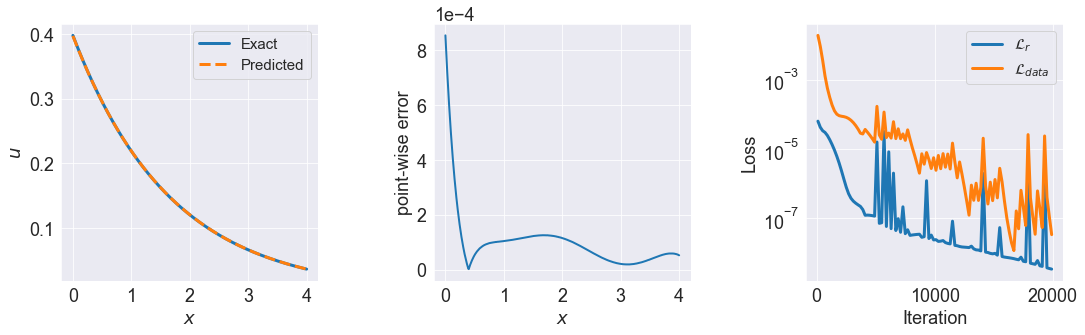

In [15]:
plt.rcParams.update({'font.size':18})
with sns.axes_style("darkgrid"):
    fig = plt.figure(3, figsize=(16, 5))
    ax = plt.subplot(1, 3, 1)
    plt.plot(x, u_star, label='Exact', linewidth=3)
    plt.plot(x, u_pred, '--', label='Predicted', linewidth=3)
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    plt.xticks([0, 1, 2, 3, 4])
    plt.legend(loc='upper right', fontsize=15)
    plt.tight_layout()
    ax.set_aspect(1./ax.get_data_ratio())

    ax = plt.subplot(1, 3, 2)
    plt.plot(x, np.abs(u_star-u_pred), linewidth=2)
    plt.xlabel('$x$')
    plt.ylabel('point-wise error')
    plt.xticks([0, 1, 2, 3, 4])
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.tight_layout()
    ax.set_aspect(1./ax.get_data_ratio())

    ax = plt.subplot(1, 3, 3)
    k = 2
    plt.plot(logger["iter"][::k], logger["loss_res"][::k], label=r"$\mathcal{L}_{r}$", linewidth=3)
    plt.plot(logger["iter"][::k], logger["loss_data"][::k], label=r"$\mathcal{L}_{data}$", linewidth=3)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend(loc='upper right', fontsize=15)
    ax.set_aspect(1./ax.get_data_ratio())
    
    plt.savefig('results_1D_poisson.png', dpi=100)
#     plt.savefig(f'{file}/results_1D_poisson.png', dpi=96, bbox_inches = 'tight')
    plt.show()

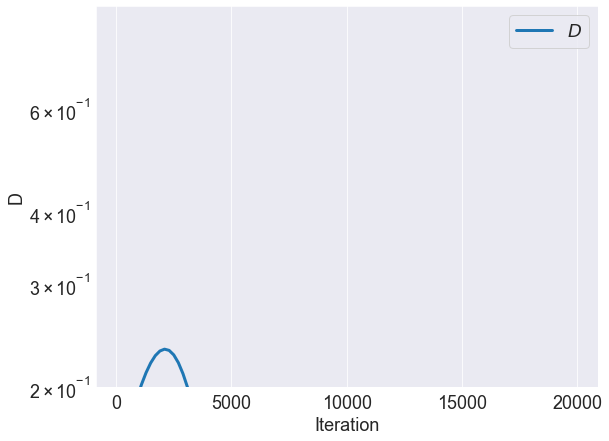

In [22]:
plt.rcParams.update({'font.size':18})
logger = np.load("./logger.npy", allow_pickle=True).item()
k = 2
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(9, 7))
    plt.subplot(111)
    # plt.plot(logger["iter"][::k], logger["loss"][::k], label=r"$L$")
    plt.plot(logger["iter"][::k], logger["D"][::k], label=r"$D$", linewidth=3)
#     plt.plot(logger["iter"][::k], logger["K"][::k], label=r"$K$", linewidth=3)
    plt.legend()
    plt.xticks([0, 5000, 10000, 15000, 20000])
    plt.ylim(0.2,0.9)
    plt.xlabel('Iteration')
    plt.ylabel('D')
    plt.yscale('log')
    plt.savefig('D.png', dpi=100)
    plt.show()

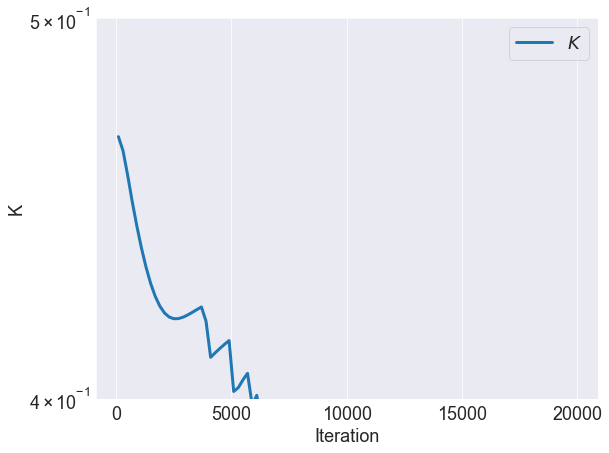

In [17]:
plt.rcParams.update({'font.size':18})
logger = np.load("./logger.npy", allow_pickle=True).item()
k = 2
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(9, 7))
    plt.subplot(111)
    # plt.plot(logger["iter"][::k], logger["loss"][::k], label=r"$L$")
#     plt.plot(logger["iter"][::k], logger["D"][::k], label=r"$D$", linewidth=3)
    plt.plot(logger["iter"][::k], logger["K"][::k], label=r"$K$", linewidth=3)
    plt.legend()
    plt.xticks([0, 5000, 10000, 15000, 20000])
    plt.ylim(0.4,0.5)
    plt.xlabel('Iteration')
    plt.ylabel('K')
    plt.yscale('log')
    plt.savefig('K.png', dpi=100)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


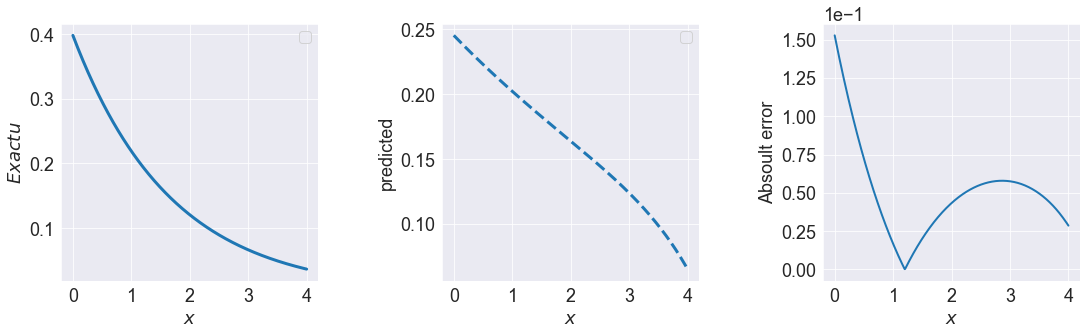

In [16]:
plt.rcParams.update({'font.size':18})
with sns.axes_style("darkgrid"):
    fig = plt.figure(3, figsize=(16, 5))
    ax = plt.subplot(1, 3, 1)
    plt.plot(x, u_star, linewidth=3)
    plt.xlabel('$x$')
    plt.ylabel('$Exact u$')
    plt.xticks([0, 1, 2, 3, 4])
    plt.legend(loc='upper right', fontsize=15)
    plt.tight_layout()
    ax.set_aspect(1./ax.get_data_ratio())

    ax = plt.subplot(1, 3, 2)
    plt.plot(x, u_pred, '--', linewidth=3)
    plt.xlabel('$x$')
    plt.ylabel('predicted')
    plt.xticks([0, 1, 2, 3, 4])
    plt.legend(loc='upper right', fontsize=15)
    #plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.tight_layout()
    ax.set_aspect(1./ax.get_data_ratio())

    ax = plt.subplot(1, 3, 3)
    plt.plot(x, np.abs(u_star-u_pred), linewidth=2)
    plt.xlabel('$x$')
    plt.ylabel('Absoult error')
    plt.xticks([0, 1, 2, 3, 4])
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.tight_layout()
    ax.set_aspect(1./ax.get_data_ratio())
    
    plt.savefig('results_1D_poisson.png', dpi=100)
#     plt.savefig(f'{file}/results_1D_poisson.png', dpi=96, bbox_inches = 'tight')
    plt.show()